In [41]:
import numpy as np
import matplotlib.pyplot as plt
import everest

import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

from astropy.timeseries import LombScargle

In [35]:
# define test object and get everest light curve (nPLD flux)
epic = 220192831
campaign= 8

lc = everest.Everest(epic, season=campaign, mission='k2')

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 220192831.


Text(0.5, 1.0, 'EPIC 220192831')

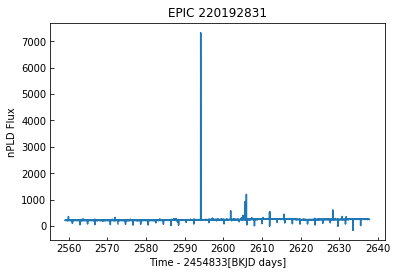

In [36]:
plt.plot(lc.time, lc.flux)
plt.xlabel("Time - 2454833[BKJD days]")
plt.ylabel("nPLD Flux")
plt.title("EPIC %s"%epic)

In [37]:
# -----------------remove those obviously spurious cadences----------------
# put flux/cadences into an array
cad = np.arange(len(lc.flux))
flux_pld = lc.flux

# turning indices found to be "bad" into a boolen mask to apply
mask = (np.isin(cad, np.concatenate([lc.nanmask, lc.badmask, lc.mask])))

# interpolate the bad cadences
interped_vals = np.interp(cad[mask], cad[~mask], flux_pld[~mask])
# replace bad cadence values with the interpolated values
flux_pld[mask] = interped_vals

Text(0.5, 1.0, 'EPIC 220192831')

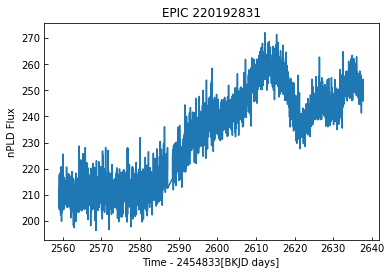

In [38]:
plt.plot(lc.time, flux_pld)
plt.xlabel("Time - 2454833[BKJD days]")
plt.ylabel("nPLD Flux")
plt.title("EPIC %s"%epic)

After the application of PLD, we remove the overall slope is added into the light curve by subtracting a linear fit from the light curve.

We also remove the first 3 days of the campaign on the grounds that the telescope is still adjusting to a new position relative to the sun, which affects the focus.

In [39]:
# -----------------do addtional cut and slope subtraction-----------------
# 30 mintue intervals between cadences
cutoff_day = 3*24*2
#cutoff = np.logical_and(cad>cutoff_day, cad<cad[-1]-5*cutoff_day)
cutoff = cad>cutoff_day
# finding linear fit
m,b = np.polyfit(cad[cutoff], flux_pld[cutoff], 1)

# subtracting it
flux_corrected = flux_pld[cutoff] - (m*cad[cutoff])

# time from the light curve
time = lc.time[cutoff]

Text(0.5, 1.0, 'EPIC 220192831')

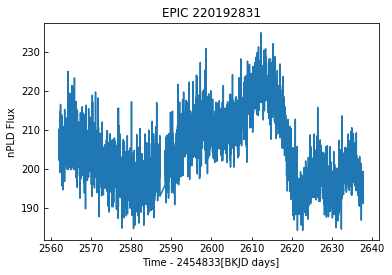

In [40]:
plt.plot(time, flux_corrected)
plt.xlabel("Time - 2454833[BKJD days]")
plt.ylabel("nPLD Flux")
plt.title("EPIC %s"%epic)

In [45]:
# Calculateing the PSD 

f = np.fft.rfftfreq(80*48, 30.0*60)

# Compute the LS based power spectrum estimates
model = LombScargle(time*86400,flux_corrected)
power_ls = model.power(f[1:-1], method="fast", normalization="psd")

# >>> To get the LS based PSD in the correct units, normalize by N <<<
power_ls /= len(time)

freq =  f[1:-1]

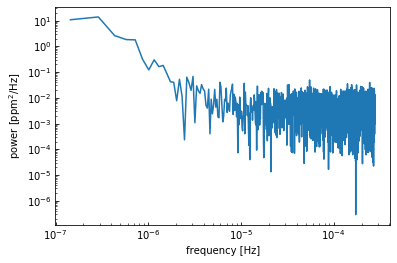

In [46]:
plt.plot(freq,power_ls)
plt.xlabel("frequency [Hz]")
plt.ylabel("power [$\mathrm{ppm}^2/\mathrm{Hz}$]")
plt.yscale("log")
plt.xscale("log")